In [1]:
from preamble import *
from preamble.dynesty.RLS_surf import *

from mesa_tricks.plots.posterior import corner_comparison_plot

In [2]:
RLS = np.load("checkpoints/RLS.npy", allow_pickle=True)[()]['summary']
RLS_surf = np.load("checkpoints/RLS_surf.npy", allow_pickle=True)[()]['summary']
RLS_solid = np.load("checkpoints/RLS_solid.npy", allow_pickle=True)[()]['summary']

from corner import corner

N1 = len(RLS['new_samples'])
N2 = len(RLS_surf['new_samples'])
N3 = len(RLS_solid['new_samples'])

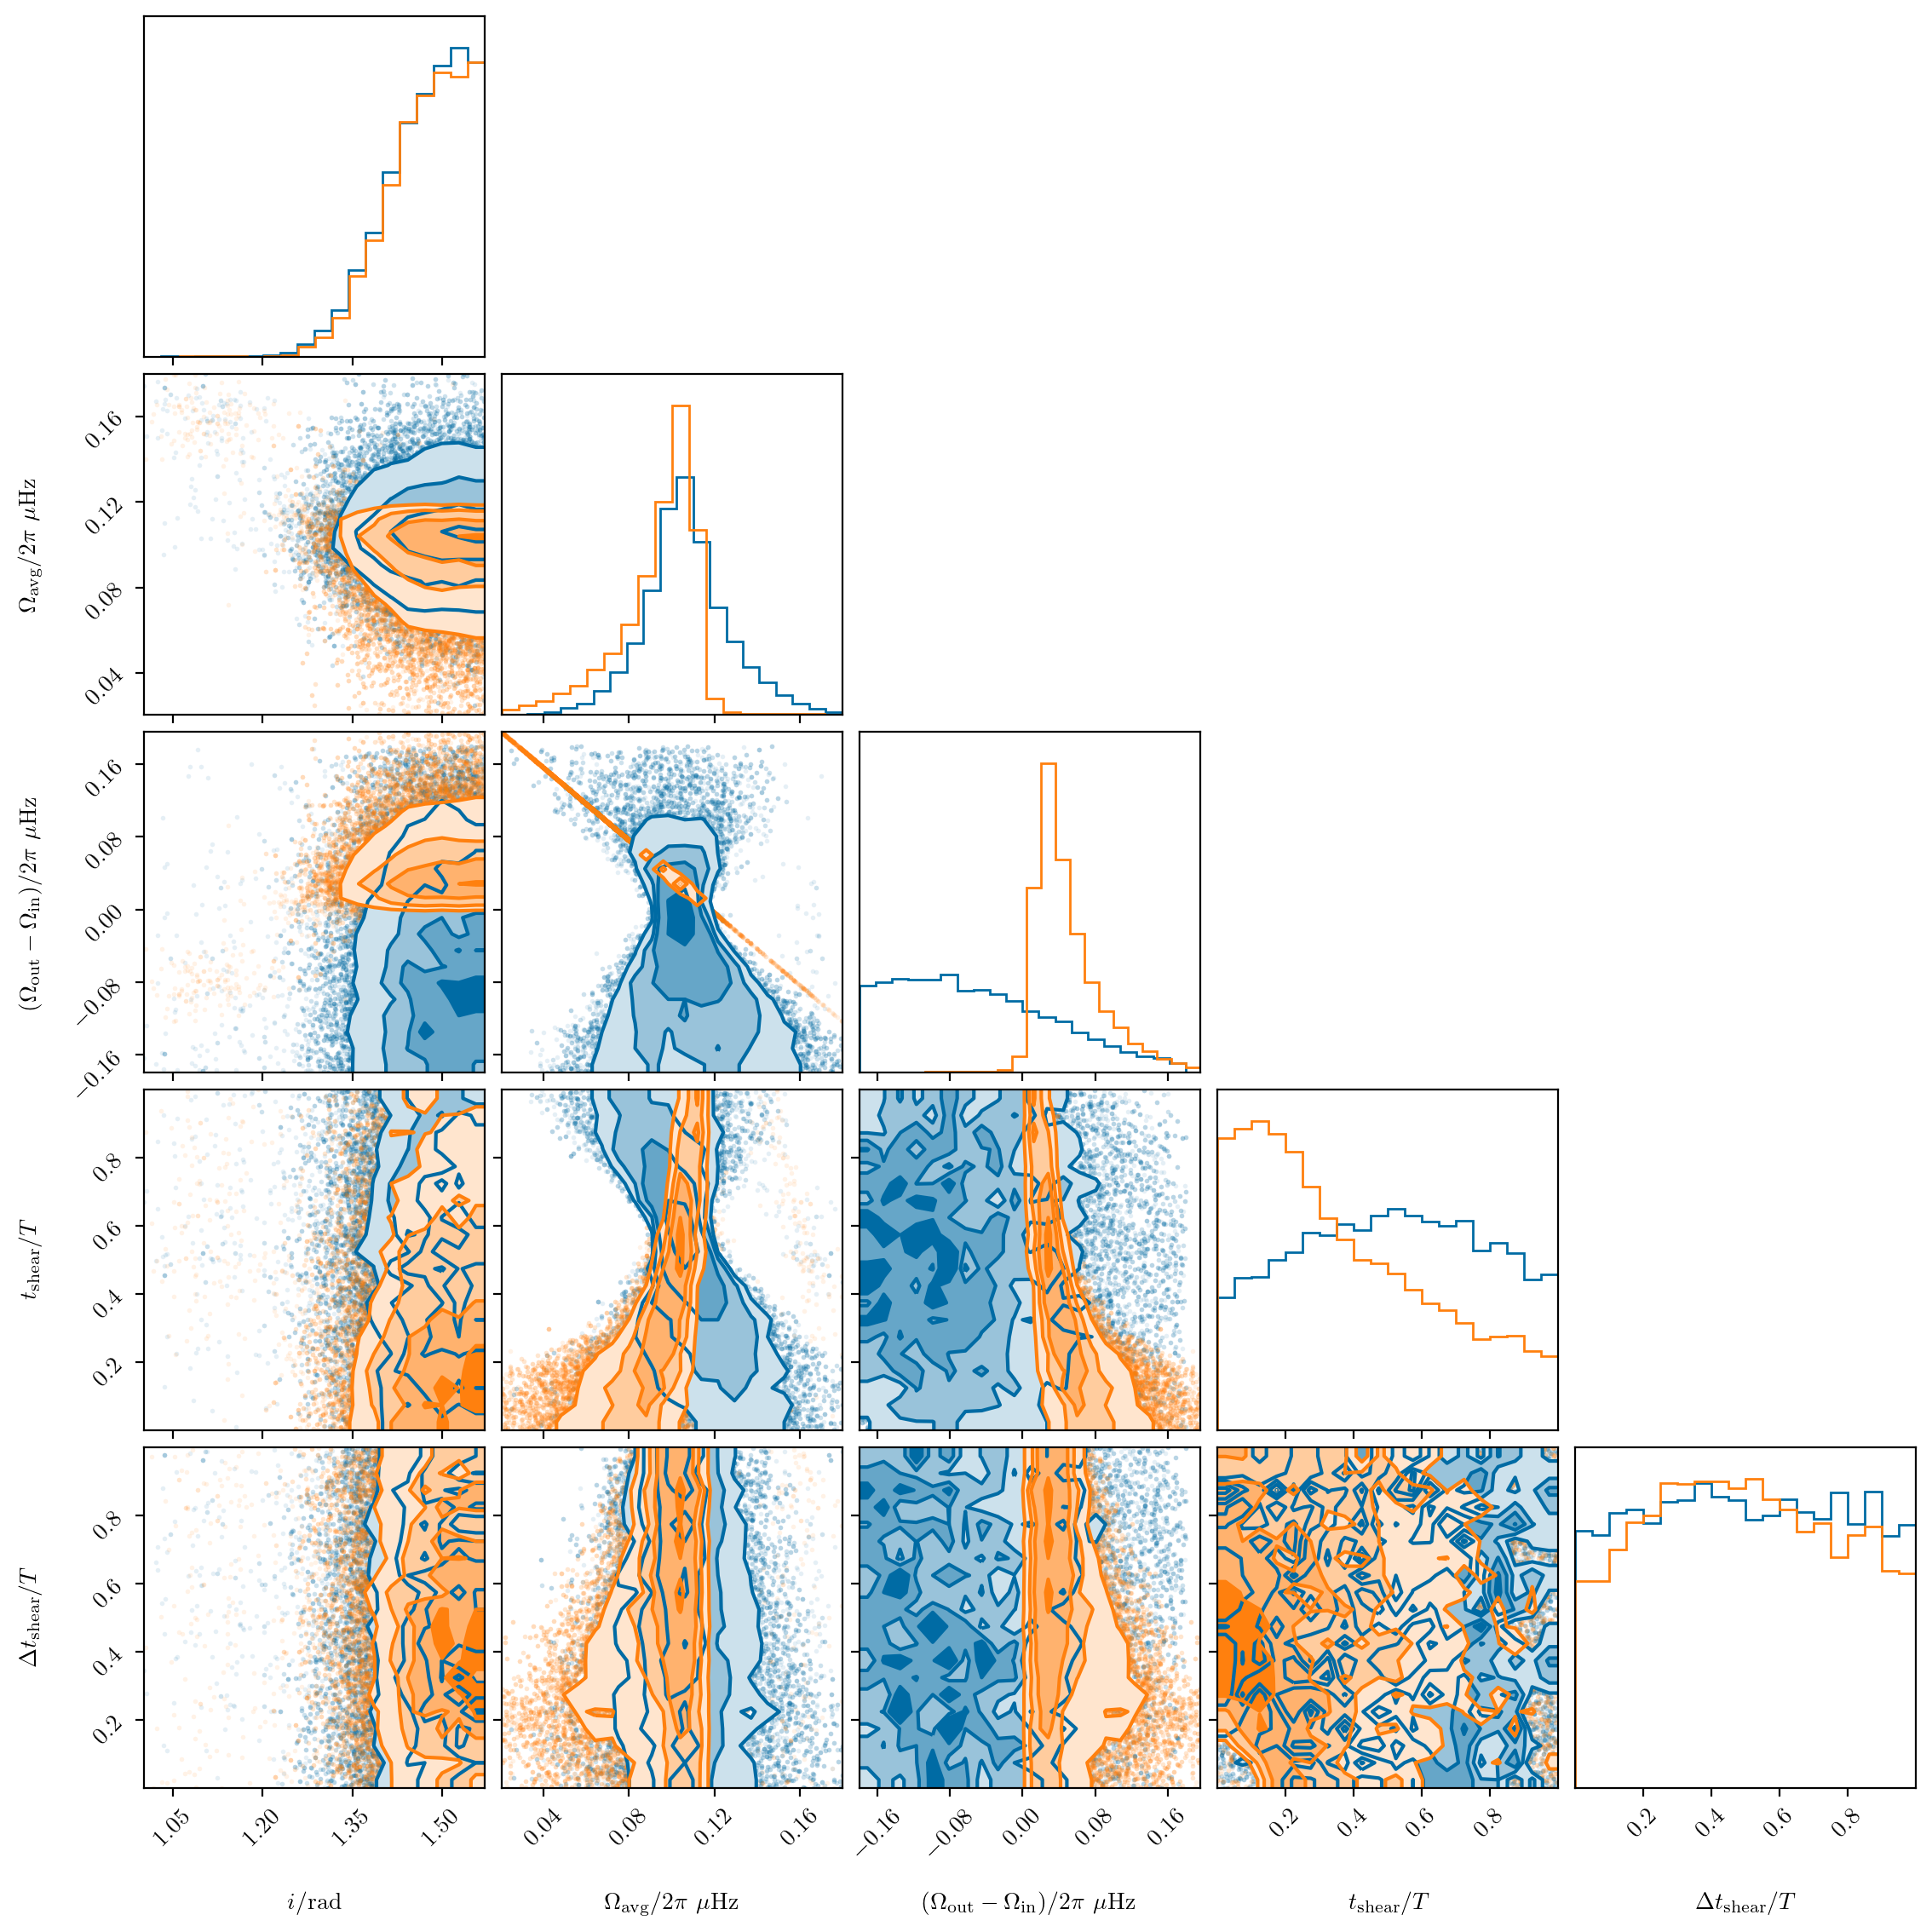

In [3]:
summary = RLS
m = summary['new_samples'][:,0] > 1
fig = corner(np.array([
        summary['new_samples'][m][:, 0],
        summary['new_samples'][m][:, 5],
        summary['new_samples'][m][:, 6],
        summary['new_samples'][m][:, 7],
        summary['new_samples'][m][:, 8]
    ]).T, labels=[shared_labels[k] for k in ['i', 'ν_rot', 'δν_rot', 't_shear', 'Δt_shear']], color='C0',
        weights=np.ones_like(summary['new_samples'][m][:, 8]) * N2/N1,
       bins=20, plot_density=False, fill_contours=True,
)

summary = RLS_surf
m = summary['new_samples'][:,0] > 1
corner(np.array([
        summary['new_samples'][m][:, 0],
        (summary['new_samples'][m][:, 5] + SURF_RATE)/2,
        SURF_RATE - summary['new_samples'][m][:, 5],
        summary['new_samples'][m][:, 6],
        summary['new_samples'][m][:, 7],
    ]).T, labels=[shared_labels[k] for k in ['i', 'ν_rot', 'δν_rot', 't_shear', 'Δt_shear']], color='C1',
       weights=np.ones_like(summary['new_samples'][m][:, 8]) * N1/N2,
       bins=20, plot_density=False, fill_contours=True, fig=fig
)

plt.show()

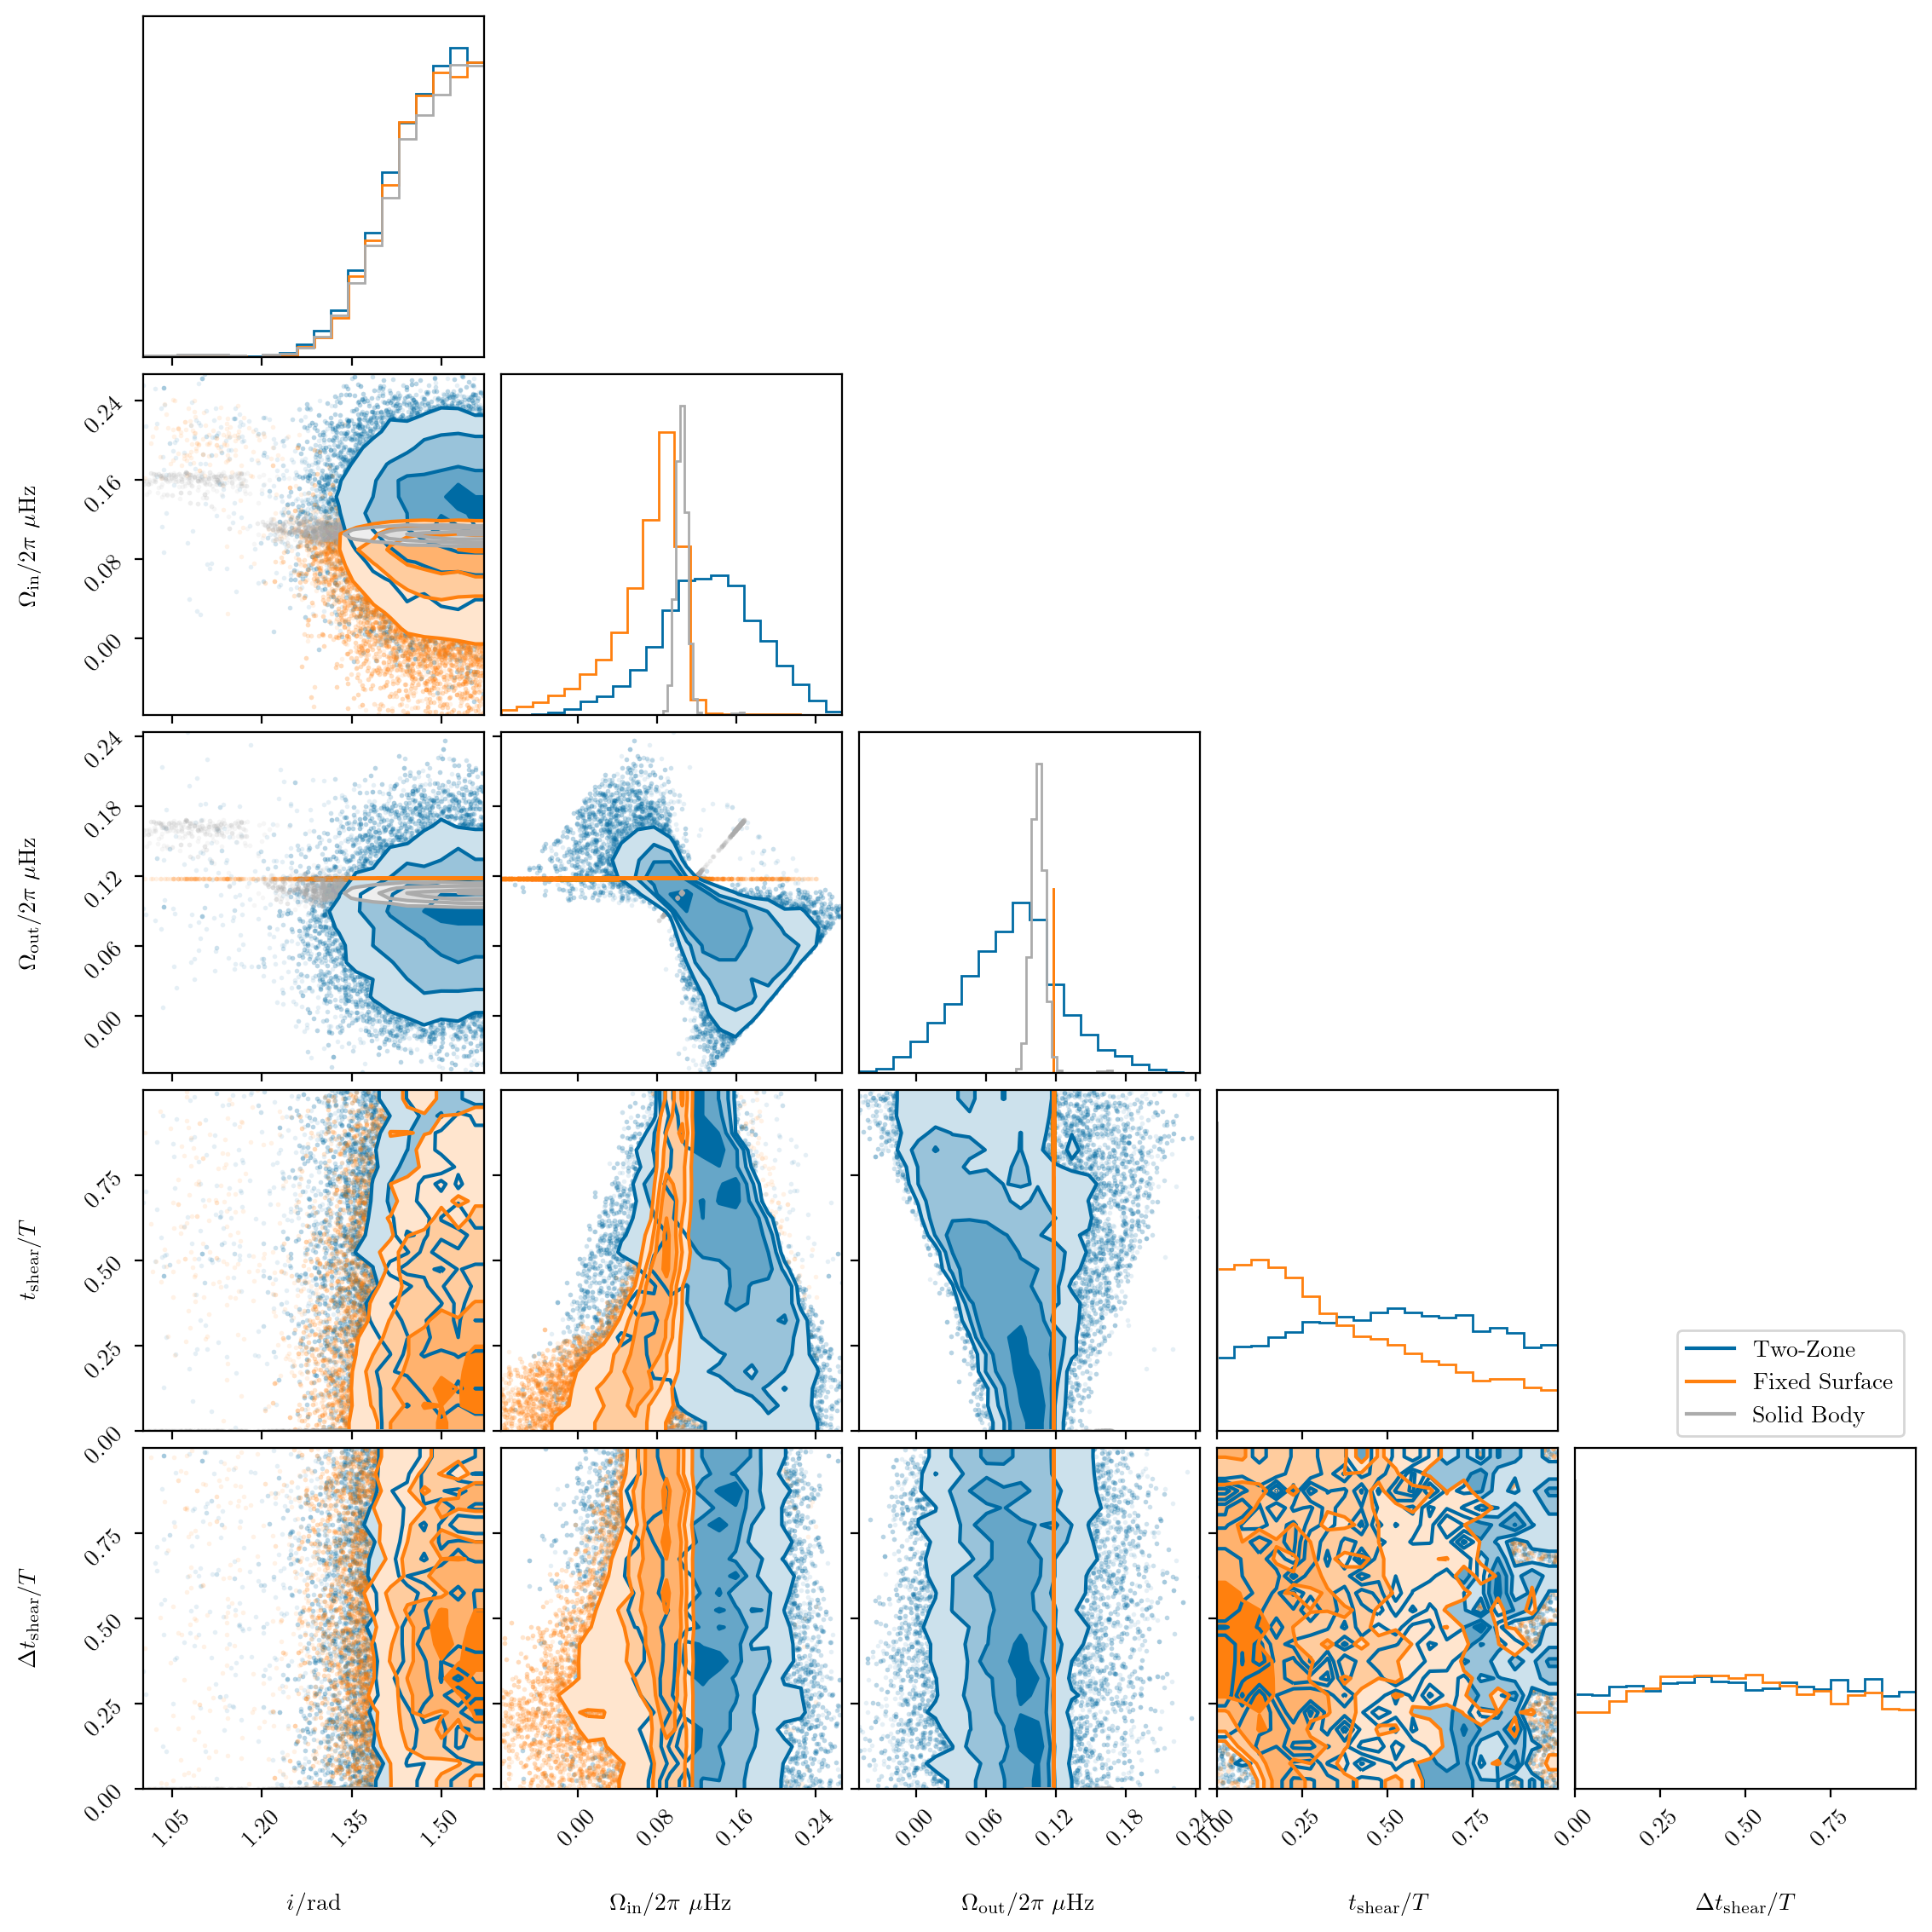

In [4]:
summary = RLS
m = summary['new_samples'][:,0] > 1
ss = np.array([
        summary['new_samples'][m][:, 0],
        summary['new_samples'][m][:, 5] - summary['new_samples'][m][:, 6]/2,
        summary['new_samples'][m][:, 5] + summary['new_samples'][m][:, 6]/2,
        summary['new_samples'][m][:, 7],
        summary['new_samples'][m][:, 8]
    ]).T
fig = corner(ss, labels=[shared_labels[k] for k in ['i', 'ν_in', 'ν_out', 't_shear', 'Δt_shear']], color='C0',
        weights=np.ones_like(summary['new_samples'][m][:, 8]) * N2/N1,
       bins=20, plot_density=False, fill_contours=True,
)

summary = RLS_surf
m = summary['new_samples'][:,0] > 1
corner(np.array([
        summary['new_samples'][m][:, 0],
        summary['new_samples'][m][:, 5],
        SURF_RATE + np.random.normal(0, 1e-5, size=len(summary['new_samples'][m][:, 5])),
        summary['new_samples'][m][:, 6],
        summary['new_samples'][m][:, 7],
    ]).T, labels=[shared_labels[k] for k in ['i', 'ν_in', 'ν_out', 't_shear', 'Δt_shear']], color='C1',
       weights=np.ones_like(summary['new_samples'][m][:, 8]) * N1/N2,
       bins=20, plot_density=False, fill_contours=True, fig=fig,
)

summary = RLS_solid
m = summary['new_samples'][:,0] > 1
corner(np.array([
        summary['new_samples'][m][:, 0],
        summary['new_samples'][m][:, 5],
        summary['new_samples'][m][:, 5],
        np.random.normal(0, 1e-5, size=len(summary['new_samples'][m][:, 5])),
        np.random.normal(0, 1e-5, size=len(summary['new_samples'][m][:, 5])),
    ]).T, labels=[shared_labels[k] for k in ['i', 'ν_in', 'ν_out', 't_shear', 'Δt_shear']], color='C2',
       weights=np.ones_like(summary['new_samples'][m][:, 8]) * N1/N2,
       bins=20, plot_density=False, fill_contours=True, fig=fig,
)
 
import matplotlib.lines as mlines
handles = [
    mlines.Line2D([], [], color='C0', label='Two-Zone'),
    mlines.Line2D([], [], color='C1', label='Fixed Surface'),
    mlines.Line2D([], [], color='C2', label='Solid Body')
]

plt.legend(handles=handles, bbox_to_anchor=(0,1,1,0), loc=4)

plt.savefig("RLS_corner.pdf", bbox_inches='tight', transparent=True)
plt.show()

  0%|          | 0/34170 [00:00<?, ?it/s]

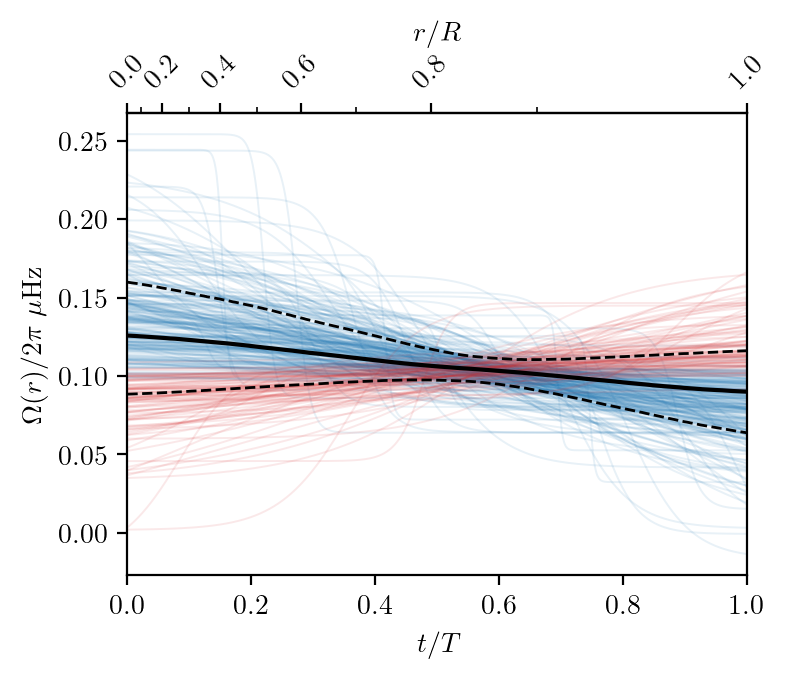

In [5]:
summary = RLS
m = slice(None, None)

ν_rot = summary['new_samples'][m][:, 5]
δν_rot = summary['new_samples'][m][:, 6]

ν_in = ν_rot - δν_rot/2
ν_out = ν_rot + δν_rot/2

t_shear = summary['new_samples'][m][:, 7]
Δt_shear = summary['new_samples'][m][:, 8]

tt = np.linspace(0, 1, 1000)

all_profiles = np.array([rotational_profile(tt, a, b, c, d) for a, b, c, d in zip(tqdm(ν_rot), δν_rot, t_shear, Δt_shear)])
Δ = [_[-1] - _[0] for _ in all_profiles]
a = np.argsort(Δ)

for i in range(1, len(ν_rot), 100):
    p = all_profiles[a[i]]
    plt.plot(tt, p, alpha=.1, c='tab:blue' if p[-1] < p[0] else 'tab:red', lw=.7)

plt.plot(tt, np.median(all_profiles, axis=0), c='black')

from scipy.stats import norm
for z in (-1, 1):
    plt.plot(tt, np.quantile(all_profiles, norm.cdf(z), axis=0), c='black', lw=1, ls='dashed')

plt.xlim(0, 1)
plt.xlabel(r"$t/T$")
plt.ylabel(r"$\Omega(r)/2\pi\ \mu$Hz")

# secondary x-xaxis

R = float(eig[1]._info[0].R_star)
secax = plt.gca().secondary_xaxis('top', functions=(lambda x: np.interp(x, t[1], eig[1].r/R),
                                                    lambda x: np.interp(x, eig[1].r/R, t[1])))

from matplotlib.ticker import FixedLocator
secax.set_xlabel('$r/R$')
for tick in secax.get_xticklabels():
    tick.set_rotation(45)
secax.xaxis.set_minor_locator(FixedLocator(np.arange(5)*.2+.1))

plt.gcf().set_size_inches(4,3)
plt.savefig(r"RLS.pdf", bbox_inches='tight', transparent=True)

  0%|          | 0/35824 [00:00<?, ?it/s]

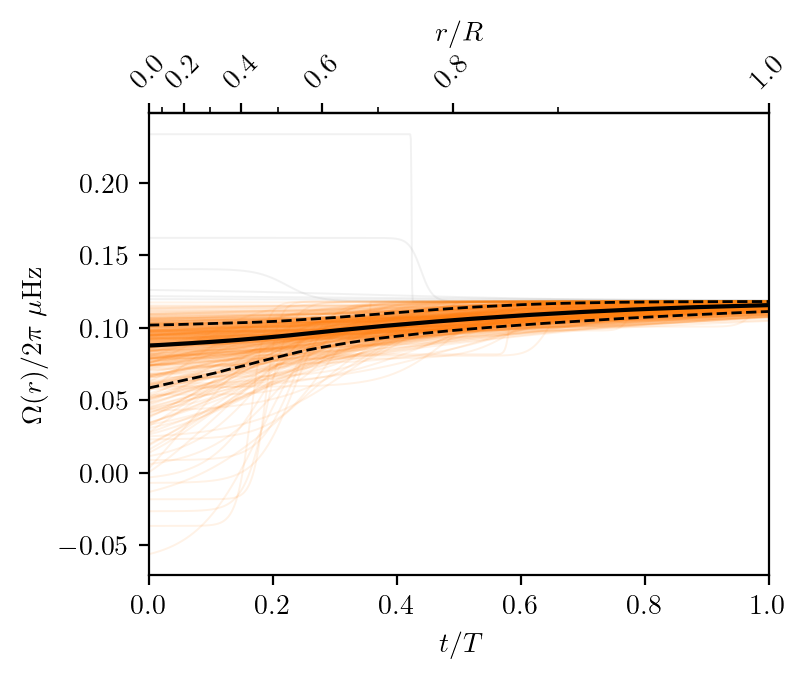

In [6]:
summary = RLS_surf
m = slice(None, None)

ν_in = summary['new_samples'][m][:, 5]
ν_out = SURF_RATE

ν_rot = (ν_in + ν_out)/2
δν_rot = ν_out - ν_in

t_shear = summary['new_samples'][m][:, 6]
Δt_shear = summary['new_samples'][m][:, 7]

tt = np.linspace(0, 1, 1000)

all_profiles = np.array([rotational_profile(tt, a, b, c, d) for a, b, c, d in zip(tqdm(ν_rot), δν_rot, t_shear, Δt_shear)])
Δ = [_[-1] - _[0] for _ in all_profiles]
a = np.argsort(Δ)

for i in range(1, len(ν_rot), 100):
    p = all_profiles[a[i]]
    plt.plot(tt, p, alpha=.1, c='tab:gray' if p[-1] < p[0] else 'C1', lw=.7)

plt.plot(tt, np.median(all_profiles, axis=0), c='black')

from scipy.stats import norm
for z in (-1, 1):
    plt.plot(tt, np.quantile(all_profiles, norm.cdf(z), axis=0), c='black', lw=1, ls='dashed')

plt.xlim(0, 1)
plt.xlabel(r"$t/T$")
plt.ylabel(r"$\Omega(r)/2\pi\ \mu$Hz")

# secondary x-xaxis

R = float(eig[1]._info[0].R_star)
secax = plt.gca().secondary_xaxis('top', functions=(lambda x: np.interp(x, t[1], eig[1].r/R),
                                                    lambda x: np.interp(x, eig[1].r/R, t[1])))

from matplotlib.ticker import FixedLocator
secax.set_xlabel('$r/R$')
for tick in secax.get_xticklabels():
    tick.set_rotation(45)
secax.xaxis.set_minor_locator(FixedLocator(np.arange(5)*.2+.1))

plt.gcf().set_size_inches(4,3)
plt.savefig(r"RLS_surf.pdf", bbox_inches='tight', transparent=True)

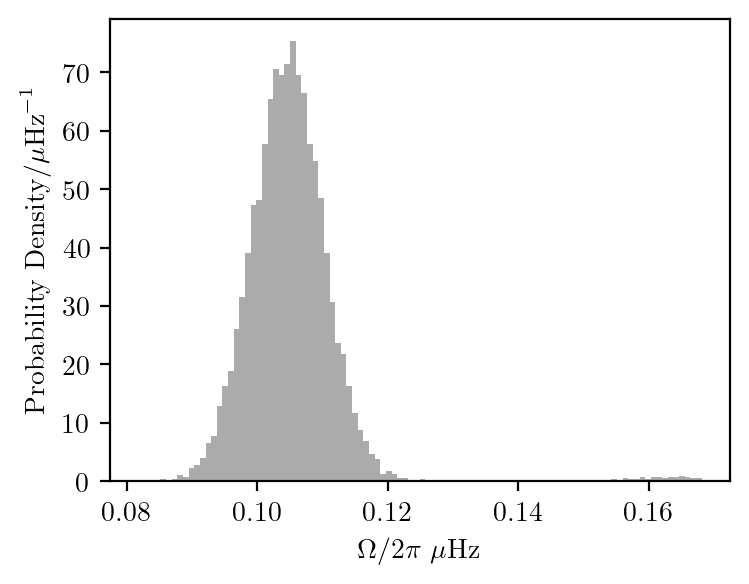

In [7]:
plt.hist(RLS_solid['new_samples'][:,5], bins=100, density=True, facecolor='C2')

plt.ylabel(r'Probability Density/$\mu\mathrm{Hz}^{-1}$')
plt.xlabel(r'$\Omega/2\pi\ \mu$Hz')

plt.gcf().set_size_inches(4,3)
plt.savefig(r"RLS_solid.pdf", bbox_inches='tight', transparent=True)